<font color = "#4477AA" ><h1>Cervical Cancer Prediction

<p>Cervical cancer is one of the most prevalent forms of cancer affecting women worldwide. Despite significant advancements in medical technology and treatment options, Cervical cancer   remains a major concern for patients and healthcare professionals. The ability to accurately predict the likelihood of Cervical cancer   can greatly assist in developing personalized treatment plans and improving patient outcomes. 
The aim of this data science project is to build a predictive model for Cervical cancer using various machine learning algorithms and statistical techniques. By analyzing a comprehensive dataset containing clinical, pathological, and demographic information of Cervical cancer patients, we seek to identify key factors that contribute to   and develop a reliable model that can assist in early detection and prevention strategies.</p>

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


## Load the dataset

In [2]:
path = "cervical-cancer_csv.csv"
df = pd.read_csv(path)
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [3]:
df.shape

(835, 36)

### Checking for columns names, data types, missing values, duplicates and number of unique classes

In [4]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing:np.nan'] = (df.isnull()).sum()
    summary_df['Missing:None'] = (df == "None").sum()
    summary_df['total'] =  summary_df['Missing:np.nan'] + summary_df['Missing:None']
    summary_df['Percent'] = 100*summary_df['total']/len(df)
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df.sort_values(ascending = False, by = 'Percent')

summary(df).style.background_gradient(cmap='Oranges')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
STDs: Time since last diagnosis,float64,764,0,764,91.497006,0,18,71
STDs: Time since first diagnosis,float64,764,0,764,91.497006,0,18,71
IUD,float64,112,0,112,13.413174,0,2,723
IUD (years),float64,112,0,112,13.413174,0,26,723
Hormonal Contraceptives,float64,103,0,103,12.335329,0,2,732
Hormonal Contraceptives (years),float64,103,0,103,12.335329,0,40,732
STDs:pelvic inflammatory disease,float64,100,0,100,11.976048,0,2,735
STDs:vulvo-perineal condylomatosis,float64,100,0,100,11.976048,0,2,735
STDs:HPV,float64,100,0,100,11.976048,0,2,735
STDs:Hepatitis B,float64,100,0,100,11.976048,0,2,735


<h1 align=center><font size = 5>Data Preprocessing - Dealing with missing values </font></h1>

* Drop columns that have high percentage of missing values
* The rest of the missing values will be handled using imputation technique

In [5]:
df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis = 1, inplace = True)

* Before fitting any transformer(imputer, encoder, or scaler),we will first split the data set into train and validation splits
* We will exclude the validation data from any type of *fitting*.This will prevent data leakage   

## Train-Test Split

In [6]:
df["Biopsy"].value_counts(normalize = True)

0    0.935329
1    0.064671
Name: Biopsy, dtype: float64

* There is a significant class imbalance, therefor We will use StratifiedShuffleSplit to deal with it

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
features_cols = [x for x in df.columns if x not in 'Biopsy']
strat_shuff_split = StratifiedShuffleSplit(n_splits =1, train_size=0.8, test_size=0.2,random_state=0)
train_index, valid_index = next(strat_shuff_split.split(df[features_cols],df["Biopsy"]))
X_train = df.loc[train_index, features_cols]
y_train = df.loc[train_index, "Biopsy"]

X_valid =df.loc[valid_index, features_cols]
y_valid = df.loc[valid_index, "Biopsy"]

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(668, 33)
(668,)
(167, 33)
(167,)


In [9]:
# lets check the percentage of each class after split 
y_valid.value_counts(normalize = True)

0    0.934132
1    0.065868
Name: Biopsy, dtype: float64

In [10]:
y_train.value_counts(normalize = True)

0    0.935629
1    0.064371
Name: Biopsy, dtype: float64

#### Before appling imputation, we need to define which columns are categoric and which are numerical

In [11]:
categorical_variables = [col for col in X_train.columns if X_train[col].nunique() < 10]
numeric_variables = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

print("Categorical variables:", categorical_variables)
print("  "*15)
print("Numeric variables:", numeric_variables)

Categorical variables: ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology']
                              
Numeric variables: ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum c

### Imputation

In [12]:
# for X_train
from sklearn.impute import SimpleImputer
impute_cats  = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
impute_num  = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X_train[categorical_variables] = impute_cats.fit_transform(X_train[categorical_variables])
X_train[numeric_variables] = impute_num.fit_transform(X_train[numeric_variables])

In [13]:
# for X_valid
X_valid[categorical_variables] = impute_cats.transform(X_valid[categorical_variables])
X_valid[numeric_variables] = impute_num.transform(X_valid[numeric_variables])

In [14]:
# lets have a look 
summary(X_train).style.background_gradient(cmap='Oranges')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
Age,float64,0,0,0,0.000000,0,40,668
STDs:syphilis,float64,0,0,0,0.000000,0,2,668
Schiller,float64,0,0,0,0.000000,0,2,668
Hinselmann,float64,0,0,0,0.000000,0,2,668
Dx,float64,0,0,0,0.000000,0,2,668
Dx:HPV,float64,0,0,0,0.000000,0,2,668
Dx:CIN,float64,0,0,0,0.000000,0,2,668
Dx:Cancer,float64,0,0,0,0.000000,0,2,668
STDs: Number of diagnosis,float64,0,0,0,0.000000,0,4,668
STDs:HPV,float64,0,0,0,0.000000,0,2,668


In [15]:
summary(X_valid).style.background_gradient(cmap='Oranges')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
Age,float64,0,0,0,0.000000,0,35,167
STDs:syphilis,float64,0,0,0,0.000000,0,2,167
Schiller,float64,0,0,0,0.000000,0,2,167
Hinselmann,float64,0,0,0,0.000000,0,2,167
Dx,float64,0,0,0,0.000000,0,2,167
Dx:HPV,float64,0,0,0,0.000000,0,2,167
Dx:CIN,float64,0,0,0,0.000000,0,2,167
Dx:Cancer,float64,0,0,0,0.000000,0,2,167
STDs: Number of diagnosis,float64,0,0,0,0.000000,0,3,167
STDs:HPV,float64,0,0,0,0.000000,0,1,167


 <h1 align=center><font size = 5>Exploratory Data Analysis </font></h1>

In [16]:
### lets combine train and validation sets to perform EDA
new_df = pd.concat([X_train, X_valid], axis = 0)
new_df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
248,25.0,2.0,18.0,2.0,0.0,0.0,0.0,1.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
513,33.0,4.0,18.0,3.0,0.0,0.0,0.0,1.0,5.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,35.0,1.0,18.0,2.0,0.0,0.0,0.0,1.0,2.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
661,70.0,1.0,16.0,10.0,0.0,0.0,0.0,0.0,0.00,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,23.0,2.0,17.0,1.0,0.0,0.0,0.0,1.0,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
new_df_uniques = new_df.nunique()
categorical_variables = list(new_df_uniques[new_df_uniques <=10].index)
numeric_variables = list(set(new_df.columns) - set(categorical_variables))
print("Categorical variables:", categorical_variables)
print("  "*15)
print("Numeric variables:", numeric_variables)

Categorical variables: ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology']
                              
Numeric variables: ['First sexual intercourse', 'Smokes (packs/year)', 'Age', 'Smokes (years)', 'Num of pregnancies', 'IUD (years)', 'Number of sexual partners', 'Hormonal Contraceptives (years)']


In [18]:
# lets view the unique values for eatch categoric variable
z = [[i, list(new_df[i].unique())] for i in categorical_variables]
z =pd.DataFrame(data = z,  columns = ['Feature', 'Classes'])
z

,Feature,Classes
0,Smokes,"[0.0, 1.0]"
1,Hormonal Contraceptives,"[1.0, 0.0]"
2,IUD,"[0.0, 1.0]"
3,STDs,"[0.0, 1.0]"
4,STDs (number),"[0.0, 1.0, 2.0, 3.0, 4.0]"
5,STDs:condylomatosis,"[0.0, 1.0]"
6,STDs:cervical condylomatosis,[0.0]
7,STDs:vaginal condylomatosis,"[0.0, 1.0]"
8,STDs:vulvo-perineal condylomatosis,"[0.0, 1.0]"
9,STDs:syphilis,"[0.0, 1.0]"


## Summary Statistics

In [19]:
num_cols = new_df[numeric_variables]
num_cols.describe().T.style.background_gradient(cmap='Oranges')

,count,mean,std,min,25%,50%,75%,max
First sexual intercourse,835.000000,17.020321,2.805154,10.000000,15.000000,17.000000,18.000000,32.000000
Smokes (packs/year),835.000000,0.465946,2.238619,0.000000,0.000000,0.000000,0.000000,37.000000
Age,835.000000,27.023952,8.482986,13.000000,21.000000,26.000000,32.000000,84.000000
Smokes (years),835.000000,1.252797,4.108337,0.000000,0.000000,0.000000,0.000000,37.000000
Num of pregnancies,835.000000,2.303147,1.406097,0.000000,1.000000,2.000000,3.000000,11.000000
IUD (years),835.000000,0.526994,1.828712,0.000000,0.000000,0.000000,0.000000,19.000000
Number of sexual partners,835.000000,2.552220,1.651366,1.000000,2.000000,2.000000,3.000000,28.000000
Hormonal Contraceptives (years),835.000000,2.304854,3.552172,0.000000,0.000000,1.000000,3.000000,30.000000


In [20]:
cat_cols = df[categorical_variables]

# This function is to view the value counts for the categorical vaiables
def value_counts(dataframe):
    for i in dataframe :
        print("\n"+ "For " + i)
        print(dataframe[i].value_counts())
        print("_______________________________")
print(value_counts(cat_cols))


For Smokes
0.0    699
1.0    123
Name: Smokes, dtype: int64
_______________________________

For Hormonal Contraceptives
1.0    477
0.0    255
Name: Hormonal Contraceptives, dtype: int64
_______________________________

For IUD
0.0    640
1.0     83
Name: IUD, dtype: int64
_______________________________

For STDs
0.0    656
1.0     79
Name: STDs, dtype: int64
_______________________________

For STDs (number)
0.0    656
2.0     37
1.0     34
3.0      7
4.0      1
Name: STDs (number), dtype: int64
_______________________________

For STDs:condylomatosis
0.0    691
1.0     44
Name: STDs:condylomatosis, dtype: int64
_______________________________

For STDs:cervical condylomatosis
0.0    735
Name: STDs:cervical condylomatosis, dtype: int64
_______________________________

For STDs:vaginal condylomatosis
0.0    731
1.0      4
Name: STDs:vaginal condylomatosis, dtype: int64
_______________________________

For STDs:vulvo-perineal condylomatosis
0.0    692
1.0     43
Name: STDs:vulvo-perin

<h3 align=center><font size = 5>Distribution of the Target Variable </font></h3>

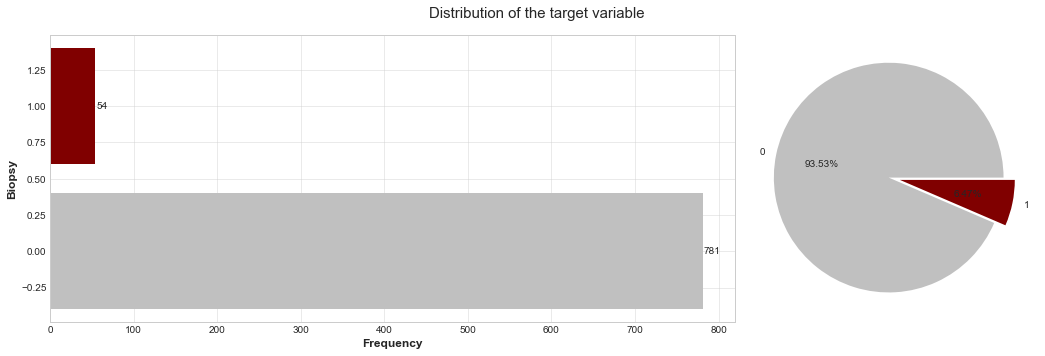

In [21]:
y = df['Biopsy'].value_counts()
colors = ["Silver","maroon" ]
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})


axes[0].barh(y=y.index, width=y.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Biopsy')
axes[0].grid(alpha=0.5)
for index, values in enumerate(y):
    axes[0].text(values+1, index, str(values), va='center')

axes[1].pie(y.values, labels=y.index, autopct='%.2f%%', explode=([0.05]*len(y.index)), colors=colors)

    

figure.suptitle('Distribution of the target variable', fontsize=15)
plt.tight_layout(pad=1)
plt.show()


<h3 align=center><font size = 5>Distribution of the Categorical Variables </font></h3>

In [22]:
def plot_bar(df, cols):
    fig, axes = plt.subplots(9, 3, figsize=(15, 40), dpi=100)
    axes = axes.flatten()

    for i, col in enumerate(cols):
        counts = df[col].value_counts()
        counts.plot.bar(ax = axes[i],color= "#4477DA")
        axes[i].set_title("Distibution of " + col)
        axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

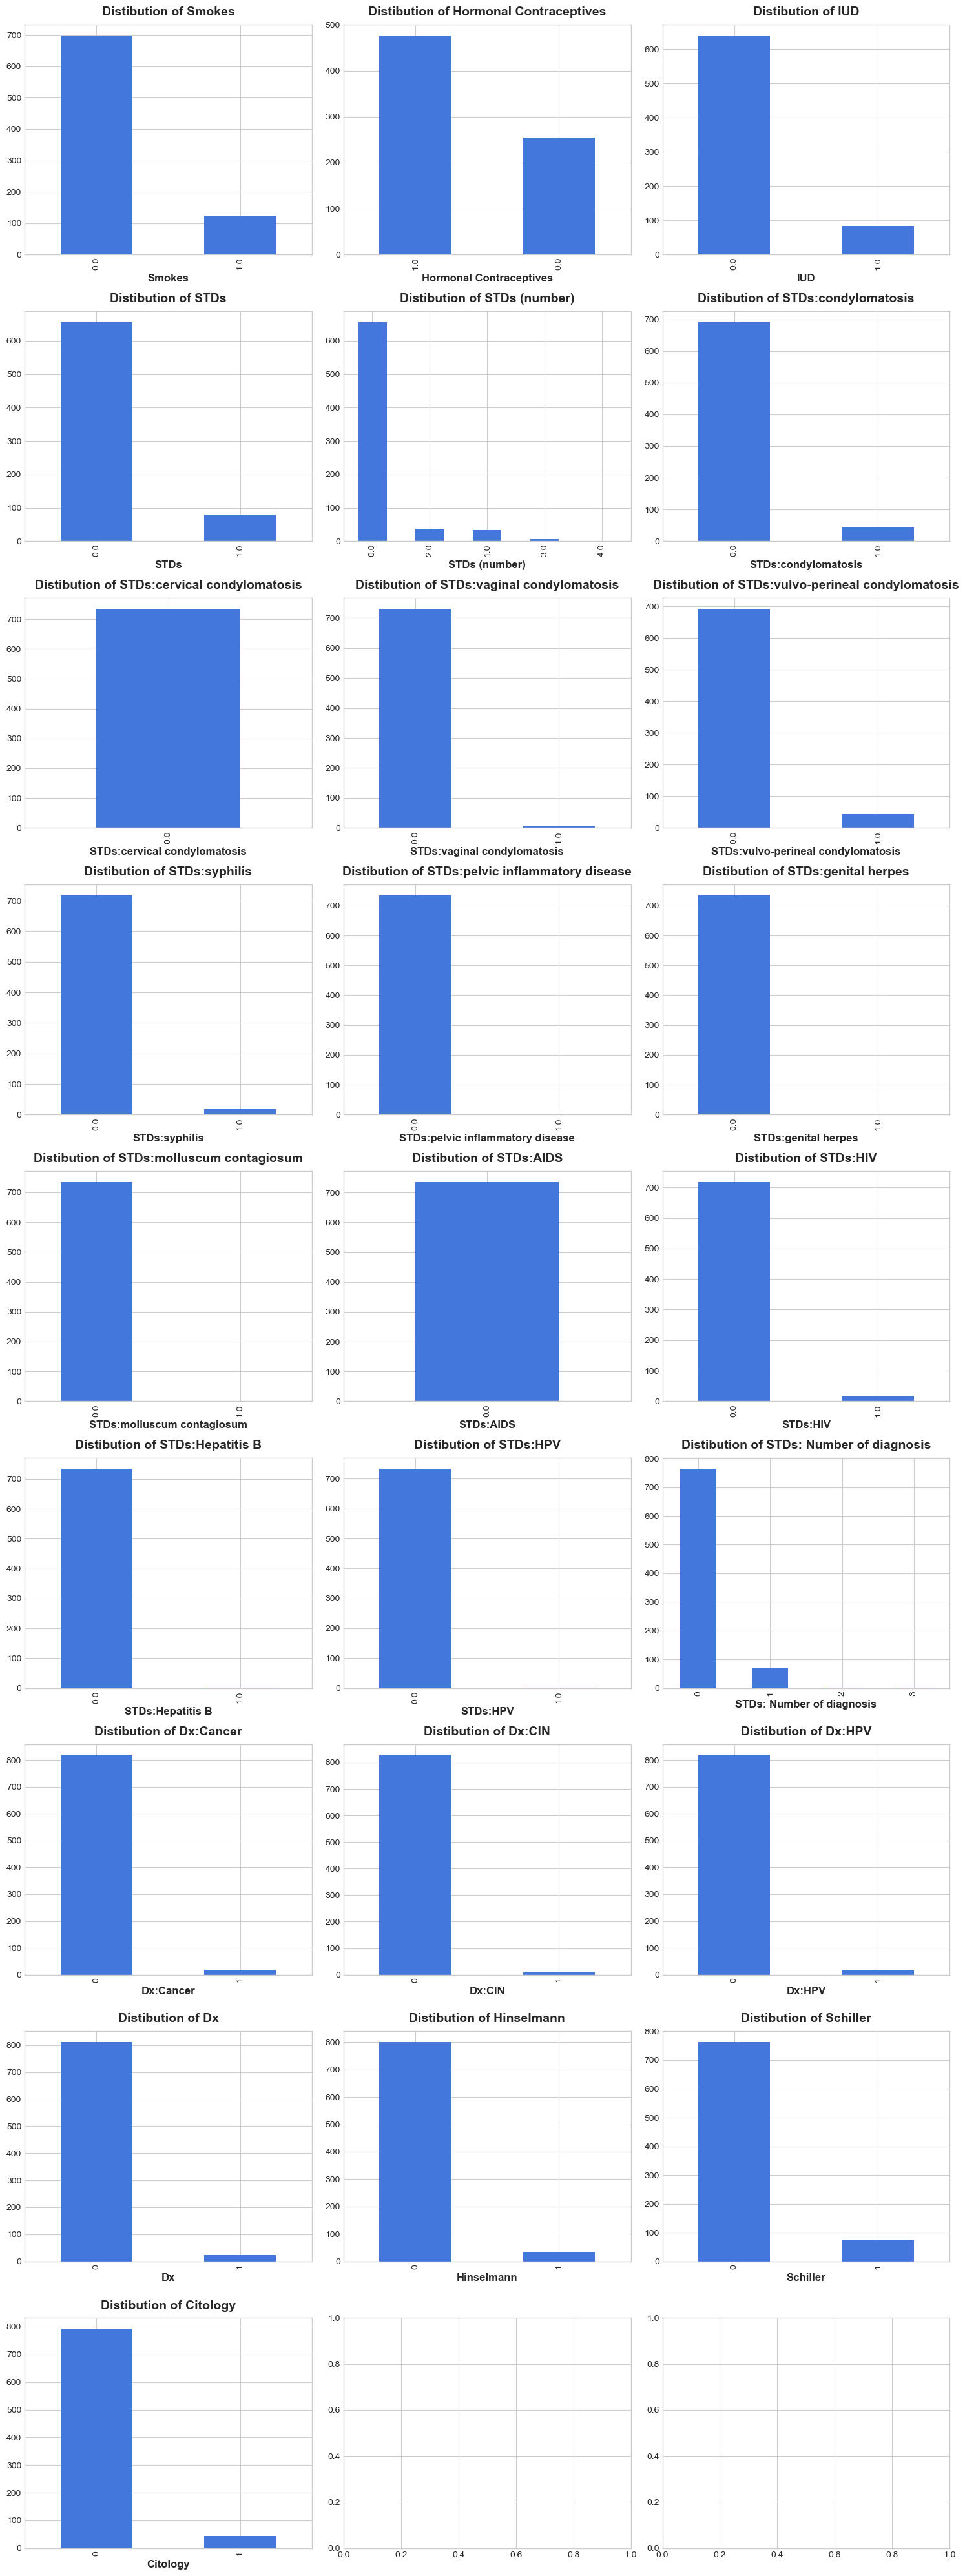

In [23]:
plot_bar(df, categorical_variables)

<h3 align=center><font size = 5>Distribution of the Numeric Variables </font></h3>

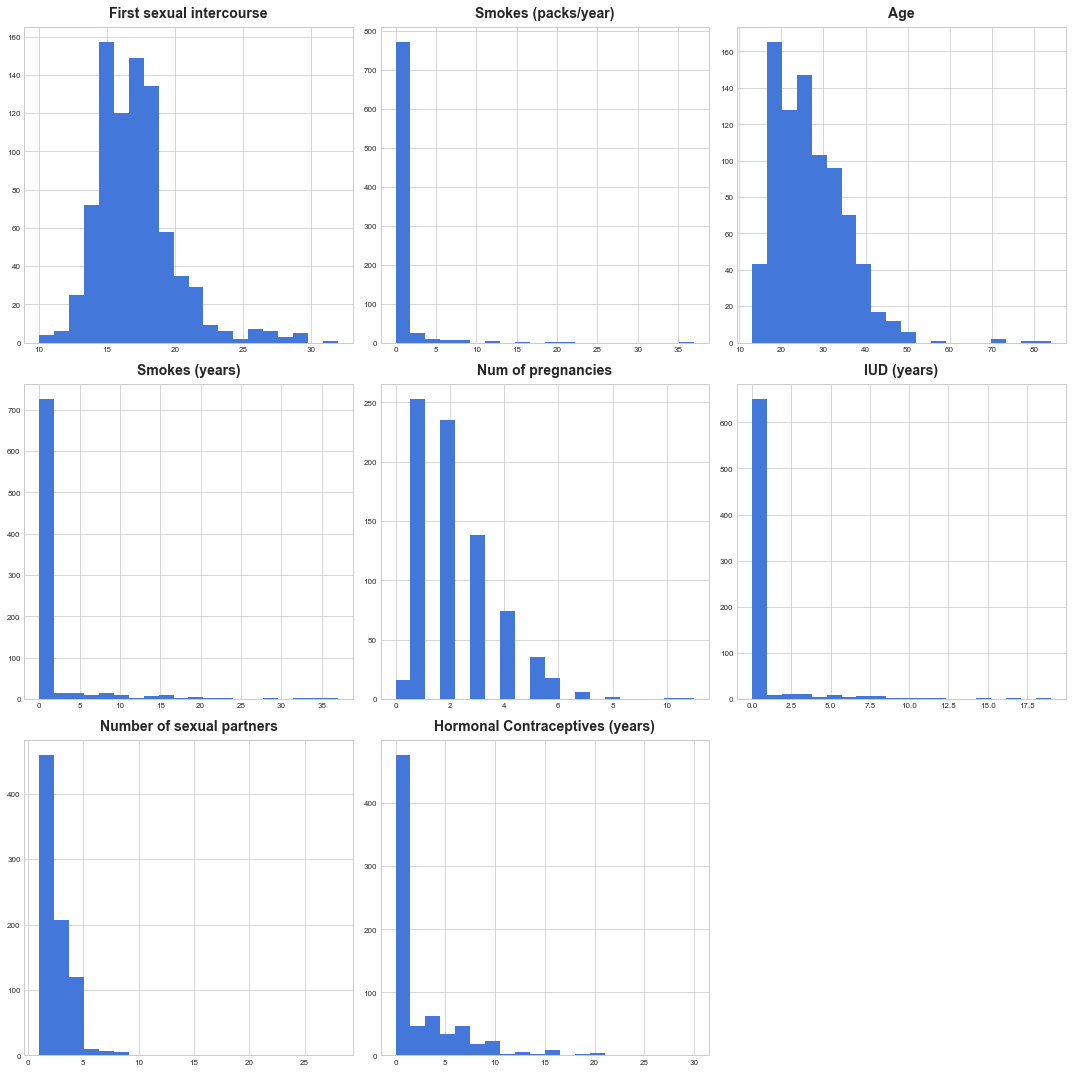

In [24]:
num = df[numeric_variables]
num.hist(figsize=(15, 15), bins=20, xlabelsize=8, ylabelsize=8,color = "#4477DA");

## Features Utility Scores

In [25]:
discrete_features = X_train.dtypes == int

In [26]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X_train,y_train,discrete_features):
    mi_scores = mutual_info_classif(X_train,y_train,discrete_features =discrete_features )
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X_train.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
mi_scores =  make_mi_scores(X_train,y_train,discrete_features) 
mi_scores

Schiller                              0.129371
Hinselmann                            0.048456
Citology                              0.030838
Num of pregnancies                    0.027445
Hormonal Contraceptives (years)       0.015685
STDs:HPV                              0.013475
STDs:AIDS                             0.007962
Dx:CIN                                0.006166
Hormonal Contraceptives               0.005967
IUD                                   0.004640
Age                                   0.004297
First sexual intercourse              0.003129
STDs:HIV                              0.002943
Dx:HPV                                0.002408
STDs: Number of diagnosis             0.002105
STDs:vaginal condylomatosis           0.001121
IUD (years)                           0.000054
STDs:Hepatitis B                      0.000000
Smokes                                0.000000
Dx                                    0.000000
Smokes (years)                        0.000000
Dx:Cancer    

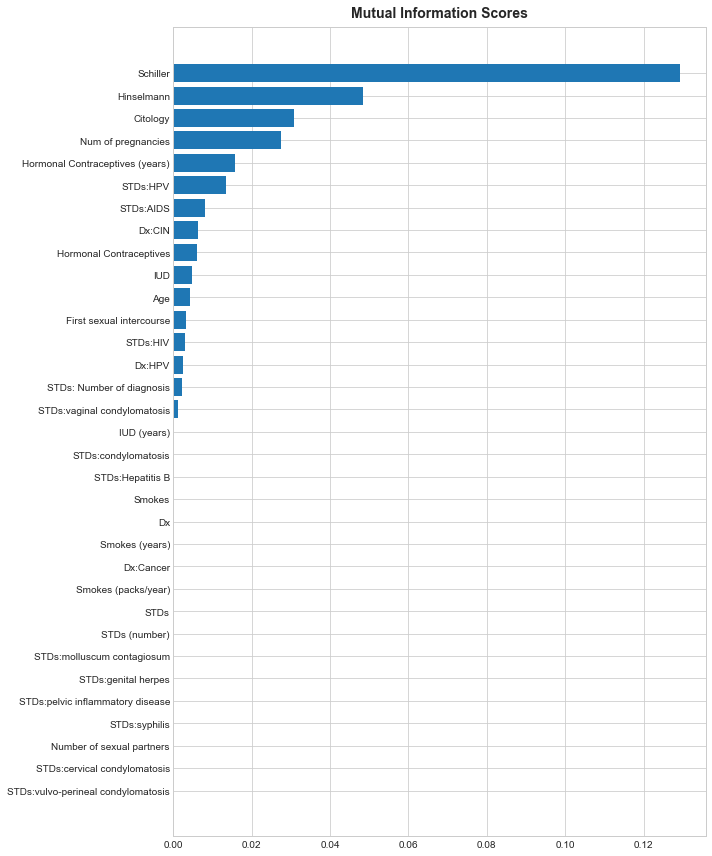

In [27]:
def plot_mi_scores(scores):
    fig, ax = plt.subplots(figsize=(10,12))
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
plot_mi_scores(mi_scores)

In [28]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]
X_train = drop_uninformative(X_train, mi_scores)
X_valid = drop_uninformative(X_valid, mi_scores)

# Features scaling

In [29]:
# X_train Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(df_scaled, columns = X_train.columns)

In [30]:
# X_valid Scaling
df_scaled = scaler.transform(X_valid)
X_valid = pd.DataFrame(df_scaled, columns = X_valid.columns)
X_valid.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Age,167.0,0.080,1.273,-1.612,-0.862,-0.112,0.763,7.138
First sexual intercourse,167.0,0.046,1.138,-2.200,-0.732,0.002,0.369,5.505
Num of pregnancies,167.0,0.055,1.076,-1.653,-0.930,-0.208,0.514,6.293
Hormonal Contraceptives,167.0,0.016,0.996,-1.503,-1.503,0.665,0.665,0.665
Hormonal Contraceptives (years),167.0,-0.019,0.904,-0.641,-0.641,-0.364,-0.000,4.610
IUD,167.0,-0.040,0.948,-0.337,-0.337,-0.337,-0.337,2.970
IUD (years),167.0,0.012,1.186,-0.297,-0.297,-0.297,-0.297,9.369
STDs:vaginal condylomatosis,167.0,0.022,1.157,-0.067,-0.067,-0.067,-0.067,14.888
STDs:AIDS,167.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
STDs:HIV,167.0,0.135,1.405,-0.135,-0.135,-0.135,-0.135,7.394


## Helper functions

### Ploting Confusion Matrix and Classification Report

In [31]:
from sklearn import metrics
def clf_plot(y_pred) :
    cm = metrics.confusion_matrix(y_valid, y_pred,normalize='true')
    cr = pd.DataFrame(metrics.classification_report(y_valid, y_pred, digits=3, output_dict=True)).T
    cr.drop(columns='support', inplace=True)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Left: Confusion Matrix
    ax[0] = sns.heatmap(cm, annot=True, fmt='', cmap='YlGnBu', ax=ax[0])
    ax[0].set_xlabel('Predicted labels', fontsize=18)
    ax[0].set_ylabel('True labels', fontsize=18)
    ax[0].set_title('Confusion Matrix', fontsize=20)
    ax[0].xaxis.set_ticklabels([0,1])
    ax[0].yaxis.set_ticklabels([0,1])

    # Right: Classification Report
    ax[1] = sns.heatmap(cr, cmap='YlGnBu', annot=True, linecolor='white', linewidths=0.5, ax=ax[1])
    ax[1].xaxis.tick_top()
    ax[1].set_title('Classification Report', fontsize=20)
    plt.show()

### Plotting roc_curve

In [32]:
from sklearn.metrics import roc_curve, auc

def roc(model,y_pred):
    # Predict the probabilities of the positive class
    y_pred = model.predict_proba(X_valid)[:,1]
    y_pred.shape

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

    # Calculate the AUC score
    auc_score = auc(fpr, tpr)
    x1=np.linspace(0,1,100)
    # Plot the ROC curve
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
    plt.plot(x1,x1,label='baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for binary classification")
    plt.legend()
    plt.show()

## Modelling

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

## GaussianNB

In [34]:
model = GaussianNB()
model.fit(X_train, y_train)
y_val_pred1 =model.predict(X_valid)

In [35]:
print(f'Precision: {precision_score(y_valid, y_val_pred1)}')
print(f'Recall: {recall_score(y_valid, y_val_pred1)}')
print(f'F1-Score: {f1_score(y_valid, y_val_pred1)}')
print(f'AUROC: {roc_auc_score(y_valid, y_val_pred1)}')

Precision: 0.06626506024096386
Recall: 1.0
F1-Score: 0.12429378531073448
AUROC: 0.5032051282051282


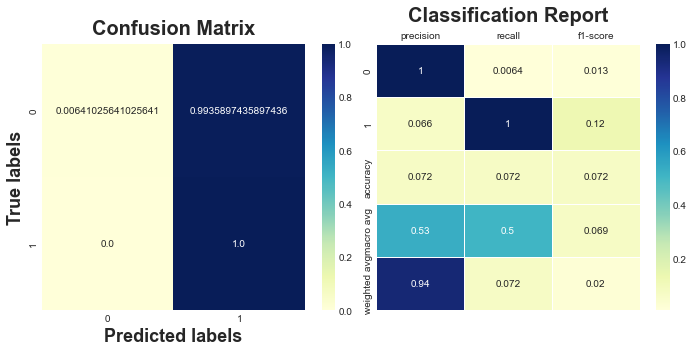

In [36]:
clf_plot(y_val_pred1)

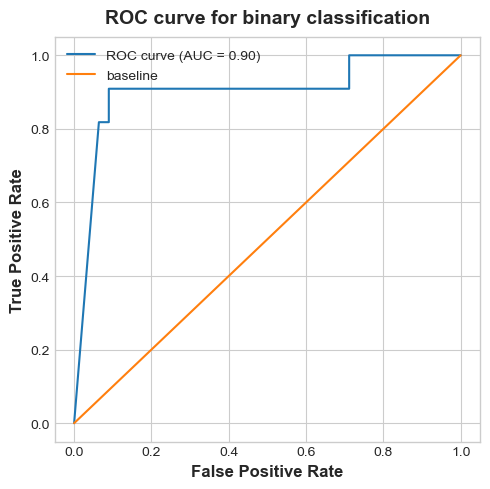

In [37]:
roc(model,y_val_pred1)

## Logistic Regression

In [38]:
# Train Log Regression
lr = LogisticRegression(max_iter=400,random_state=42).fit(X_train, y_train)
y_val_pred2 = lr.predict(X_valid)

print(f'Precision: {precision_score(y_valid, y_val_pred2)}')
print(f'Recall: {recall_score(y_valid, y_val_pred2)}')
print(f'F1-Score: {f1_score(y_valid, y_val_pred2)}')
print(f'AUROC: {roc_auc_score(y_valid, y_val_pred2)}')

Precision: 0.8
Recall: 0.7272727272727273
F1-Score: 0.761904761904762
AUROC: 0.8572261072261073


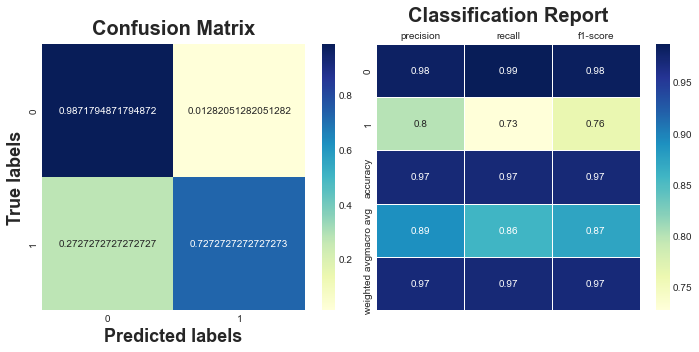

In [39]:
clf_plot(y_val_pred2)

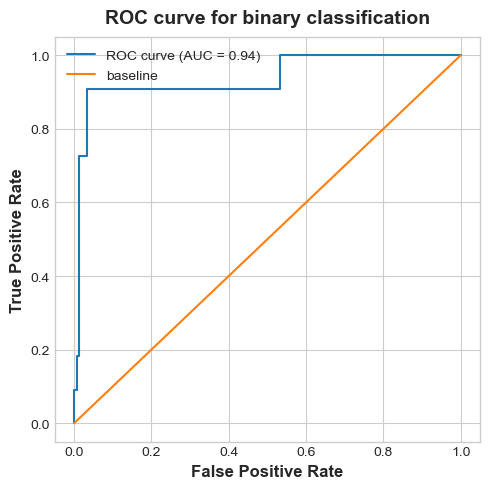

In [40]:
roc(lr,y_val_pred2)

## RFC

In [41]:
# RFC
rfc = RandomForestClassifier(max_depth=15,random_state=42).fit(X_train, y_train)
y_val_pred3 = rfc.predict(X_valid)
print(f'Precision: {precision_score(y_valid, y_val_pred3)}')
print(f'Recall: {recall_score(y_valid, y_val_pred3)}')
print(f'F1-Score: {f1_score(y_valid, y_val_pred3)}')
print(f'AUROC: {roc_auc_score(y_valid, y_val_pred3)}')

Precision: 0.7
Recall: 0.6363636363636364
F1-Score: 0.6666666666666666
AUROC: 0.8085664335664335


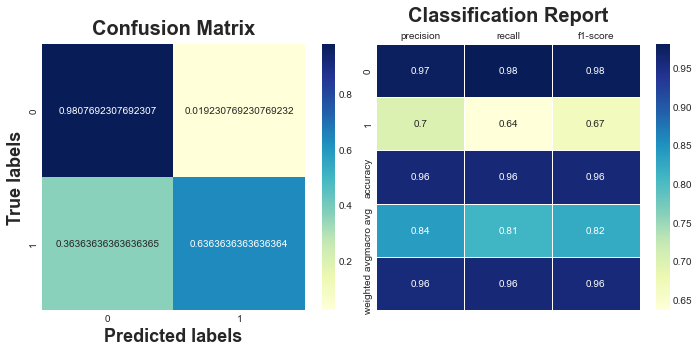

In [42]:
clf_plot(y_val_pred3)

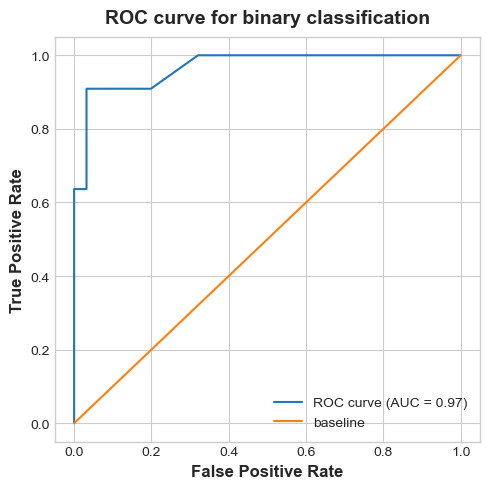

In [43]:
roc(rfc,y_val_pred3)

## KNN

In [44]:
knn = KNeighborsClassifier().fit(X_train, y_train)
y_val_pred4 = knn.predict(X_valid)
print(f'Precision: {precision_score(y_valid, y_val_pred4)}')
print(f'Recall: {recall_score(y_valid, y_val_pred4)}')
print(f'F1-Score: {f1_score(y_valid, y_val_pred4)}')
print(f'AUROC: {roc_auc_score(y_valid, y_val_pred4)}')

Precision: 0.625
Recall: 0.45454545454545453
F1-Score: 0.5263157894736842
AUROC: 0.7176573426573426


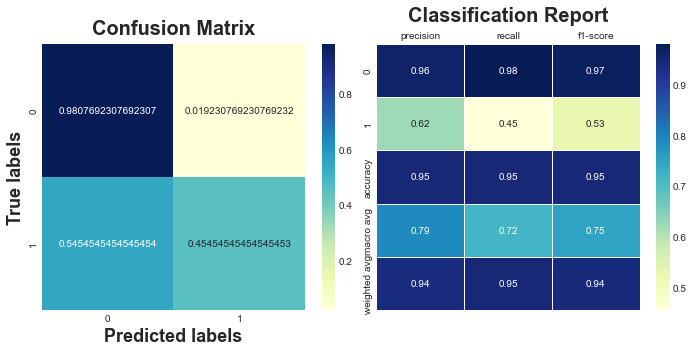

In [45]:
clf_plot(y_val_pred4)

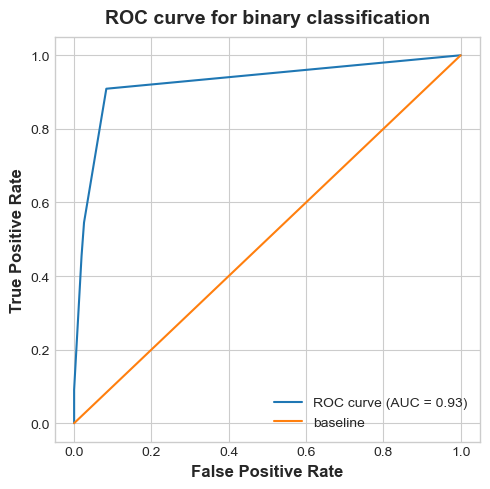

In [46]:
roc(knn,y_val_pred4)

## Decision Tree Classifier

In [47]:
# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)

tree.fit(X_train, y_train)
y_val_pred5 = tree.predict(X_valid)
print(f'Precision: {precision_score(y_valid, y_val_pred5)}')
print(f'Recall: {recall_score(y_valid, y_val_pred5)}')
print(f'F1-Score: {f1_score(y_valid, y_val_pred5)}')
print(f'AUROC: {roc_auc_score(y_valid, y_val_pred5)}')

Precision: 0.7
Recall: 0.6363636363636364
F1-Score: 0.6666666666666666
AUROC: 0.8085664335664335


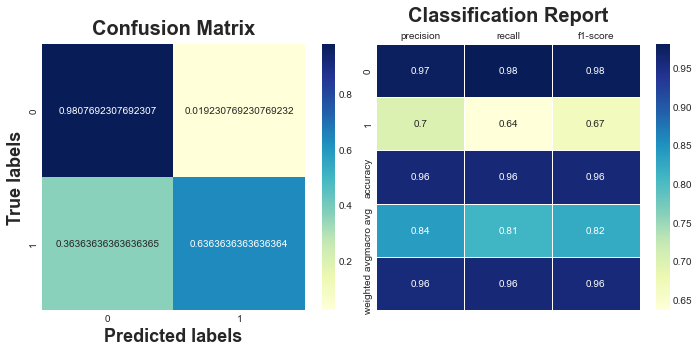

In [48]:
clf_plot(y_val_pred5)

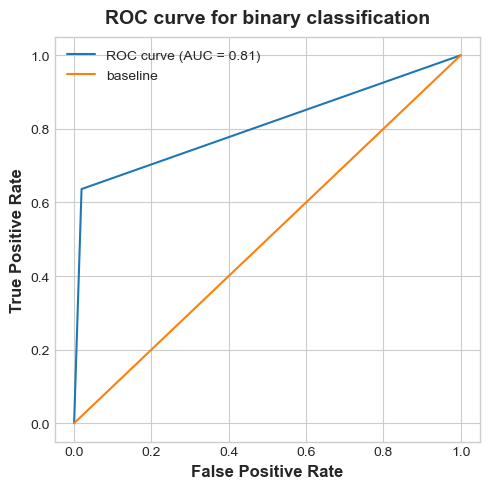

In [49]:
roc(tree,y_val_pred5)

## MLPClassifier

In [50]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(random_state=42).fit(X_train, y_train)
y_val_pred6 = MLP.predict(X_valid)

print(f'Precision: {precision_score(y_valid, y_val_pred6)}')
print(f'Recall: {recall_score(y_valid, y_val_pred6)}')
print(f'F1-Score: {f1_score(y_valid, y_val_pred6)}')
print(f'AUROC: {roc_auc_score(y_valid, y_val_pred6)}')

Precision: 0.7272727272727273
Recall: 0.7272727272727273
F1-Score: 0.7272727272727273
AUROC: 0.854020979020979


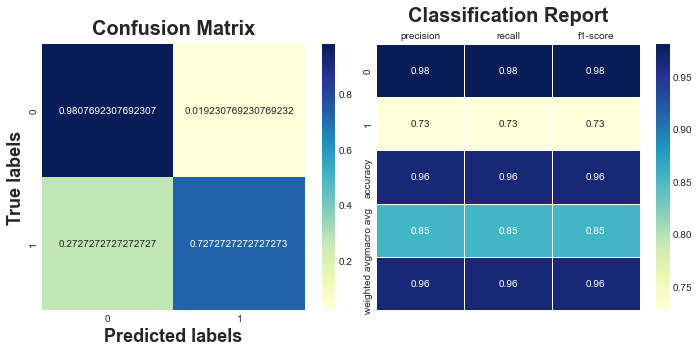

In [51]:
clf_plot(y_val_pred6)

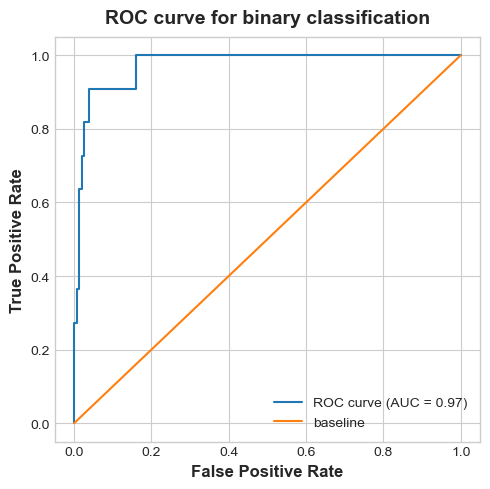

In [52]:
roc(MLP,y_val_pred6)

## Conclusion


### Comparing models performance


In [53]:
def measure_error(y_valid, y_val_pred, label):
    return pd.Series({"Accuracy": accuracy_score(y_valid, y_val_pred),
                     "Precision": precision_score(y_valid, y_val_pred),
                     "Recall": recall_score(y_valid, y_val_pred),
                     "F1": f1_score(y_valid, y_val_pred),
                     "AUROC": roc_auc_score(y_valid, y_val_pred)}, 
                     name = label)

In [54]:
GaussianNB = pd.concat([measure_error(y_valid, y_val_pred1,"GaussianNB")],axis = 1)
Log_reg = pd.concat([measure_error(y_valid, y_val_pred2,"Log_reg")],axis = 1)
RFC = pd.concat([measure_error(y_valid, y_val_pred3,"RFC")],axis = 1)
KNN = pd.concat([measure_error(y_valid, y_val_pred4,"KNN")],axis = 1)
DT = pd.concat([measure_error(y_valid, y_val_pred5,"DT")],axis = 1)
MLP = pd.concat([measure_error(y_valid, y_val_pred6,"MLP")],axis = 1)

In [55]:
compare_models =  pd.concat([GaussianNB,Log_reg,RFC,KNN,DT,MLP],axis =1)
compare_models.style.background_gradient(cmap='Reds')

,GaussianNB,Log_reg,RFC,KNN,DT,MLP
Accuracy,0.071856,0.970060,0.958084,0.946108,0.958084,0.964072
Precision,0.066265,0.800000,0.700000,0.625000,0.700000,0.727273
Recall,1.000000,0.727273,0.636364,0.454545,0.636364,0.727273
F1,0.124294,0.761905,0.666667,0.526316,0.666667,0.727273
AUROC,0.503205,0.857226,0.808566,0.717657,0.808566,0.854021


## Result :

### Based on the above output, best algorithm base on F1 Score is : Logistic Regression

## Optimizing the best model performance


In [56]:
from sklearn.model_selection import GridSearchCV
# Dictionary to define parameters to test in algorithm
parameters = {
    'C' : [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'class_weight' : ['balanced'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

lr = LogisticRegression(multi_class = "ovr")

In [57]:
lr_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=4).fit(X_train, y_train)

In [58]:
print('Tuned hyperparameters : ', lr_cv.best_params_)
print('accuracy : ', lr_cv.best_score_)

Tuned hyperparameters :  {'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
accuracy :  0.9565868263473054


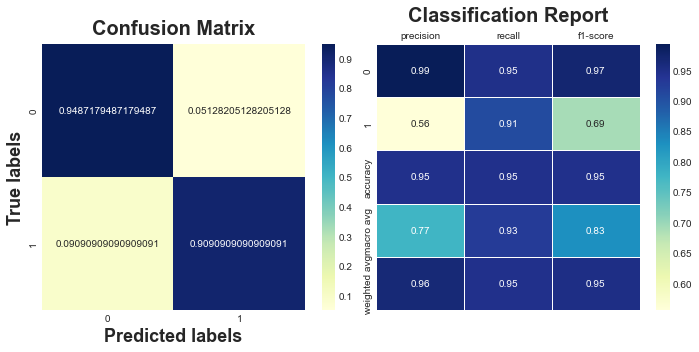

In [59]:
best_model = lr_cv.best_estimator_
yhat_train = best_model.predict(X_train)
yhat_test = best_model.predict(X_valid)
clf_plot(yhat_test)

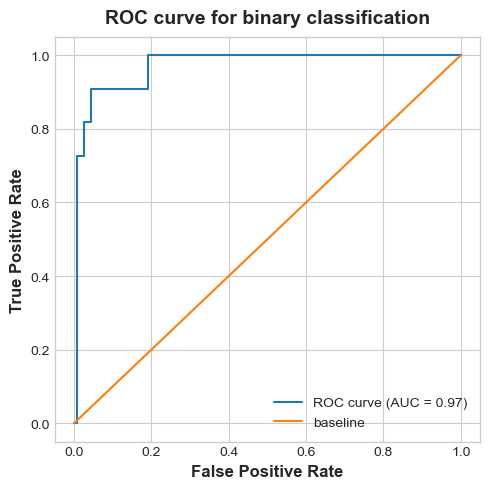

In [60]:
roc(best_model,yhat_test)

---
END

Thank you :)